In [94]:
#python libraries
import os
import re
import copy

#other ML libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#ploting
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
# Setting random seeds for reproducibility
random_seed = 420
np.random.seed(random_seed)
_ = torch.manual_seed(random_seed)

### DATA CLEANING

In [4]:
#Import Disruptive & Netatmo Sensor Data

# assign variables
directory = './storedData/'
sensor_data = pd.DataFrame()
sensor_data['timestamp'] = None #in order to merge based on it 

measurement_types = ["Door", "Water", "Humidity_temperature", "Humidity_humidity", 
                     "Humidifier_humidity", "Humidifier_temperature","Temperature",
                     "Hum_temperature", "Hum_humidity"]
discrete_measurement_types = ["Door", "Water"]


# iterate over files in that directory and concat into 1 big dataframe based on timestamps
for filename in os.listdir(directory): 
    file = os.path.join(directory, filename)
    if os.path.isfile(file):    
        df = pd.read_csv(file)
        df.drop(columns=df.columns[0], inplace=True) # dropping unnamed coloumn for indexing in .cvs file

        df['timestamp'] = pd.to_datetime(df['timestamp'],  utc=True)#.dt.tz_convert('Europe/Rome') #set timezone correctly if not correct in local time
        df.set_index("timestamp", inplace=True)
        for measurement_name in df.columns:
            measurement_frame = df[measurement_name].to_frame()

            measurement_name_list = re.findall("([A-Z0-9][^A-Z]*)", measurement_name) # Splitting string on capital letters
            measurement_type = measurement_name_list[-1]
            if measurement_type not in measurement_types: #Temperature measurements does not have temperature in their name
                measurement_type = "Temperature"
                measurement_name_list.append(measurement_type)
            #Renaming coloumn for consistent naming
            coloumn_name = f"{''.join(measurement_name_list[:-1])}_{measurement_type.lower()}"
            measurement_frame.rename(columns={measurement_frame.columns[0]: coloumn_name}, inplace=True)
            # print(f"key: {measurement_frame.columns[0]} Value: {coloumn_name}")
            if measurement_type in discrete_measurement_types:
                #For Water Detection:
                #NOT_PRESENT == No water detected = 0
                #PRESENT     == water detected    = 1

                #For Door Sensors: - this is because sensor changes state based on if it detects objects in front of it
                #NOT_PRESENT == DOOR IS OPEN     = 0
                #PRESENT     == DOOR IS CLOSED   = 1
                
                measurement_frame.replace(['NOT_PRESENT', 'PRESENT'],[0, 1], inplace=True)
                measurement_frame = measurement_frame.resample('15T').ffill()
            else: #Contious measurement
                measurement_frame  = measurement_frame.resample('15T').mean().interpolate() #Resample to managable timestamps by taking mean of 5 minute slots and linear interpolating NaNs, i.e. 5, 10, 15, 20 minutes etc..

    
            sensor_data = pd.merge(sensor_data, measurement_frame, on='timestamp', how="outer")  

sensor_data.set_index("timestamp", inplace=True)
sensor_data.sort_index(axis=0, inplace=True) #Sorting by timestamp
sensor_data.sort_index(axis=1, inplace=True) #Sorting columns alpabetically

#Postprocesing the data in order to get rid of the NaN Values
#ffill and fillna(0/1) to populate NaN values of the proximity with ffill and then set the values before first valid value to DOOR_CLOSED/NO_WATER
sensor_data.loc[:, sensor_data.columns.str.endswith('door')] = sensor_data.loc[:, sensor_data.columns.str.endswith('door')].ffill().fillna(1)
sensor_data.loc[:, sensor_data.columns.str.endswith('water')] = sensor_data.loc[:, sensor_data.columns.str.endswith('water')].ffill().fillna(0)


# # #linearly interpolate temperature and humidity values:
sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('temperature')].interpolate().bfill().ffill()
sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')]  = sensor_data.loc[:, sensor_data.columns.str.endswith('humidity')].interpolate().bfill().ffill()

### EXPLORATORY DATA ANALYSIS ###

<AxesSubplot: xlabel='timestamp'>

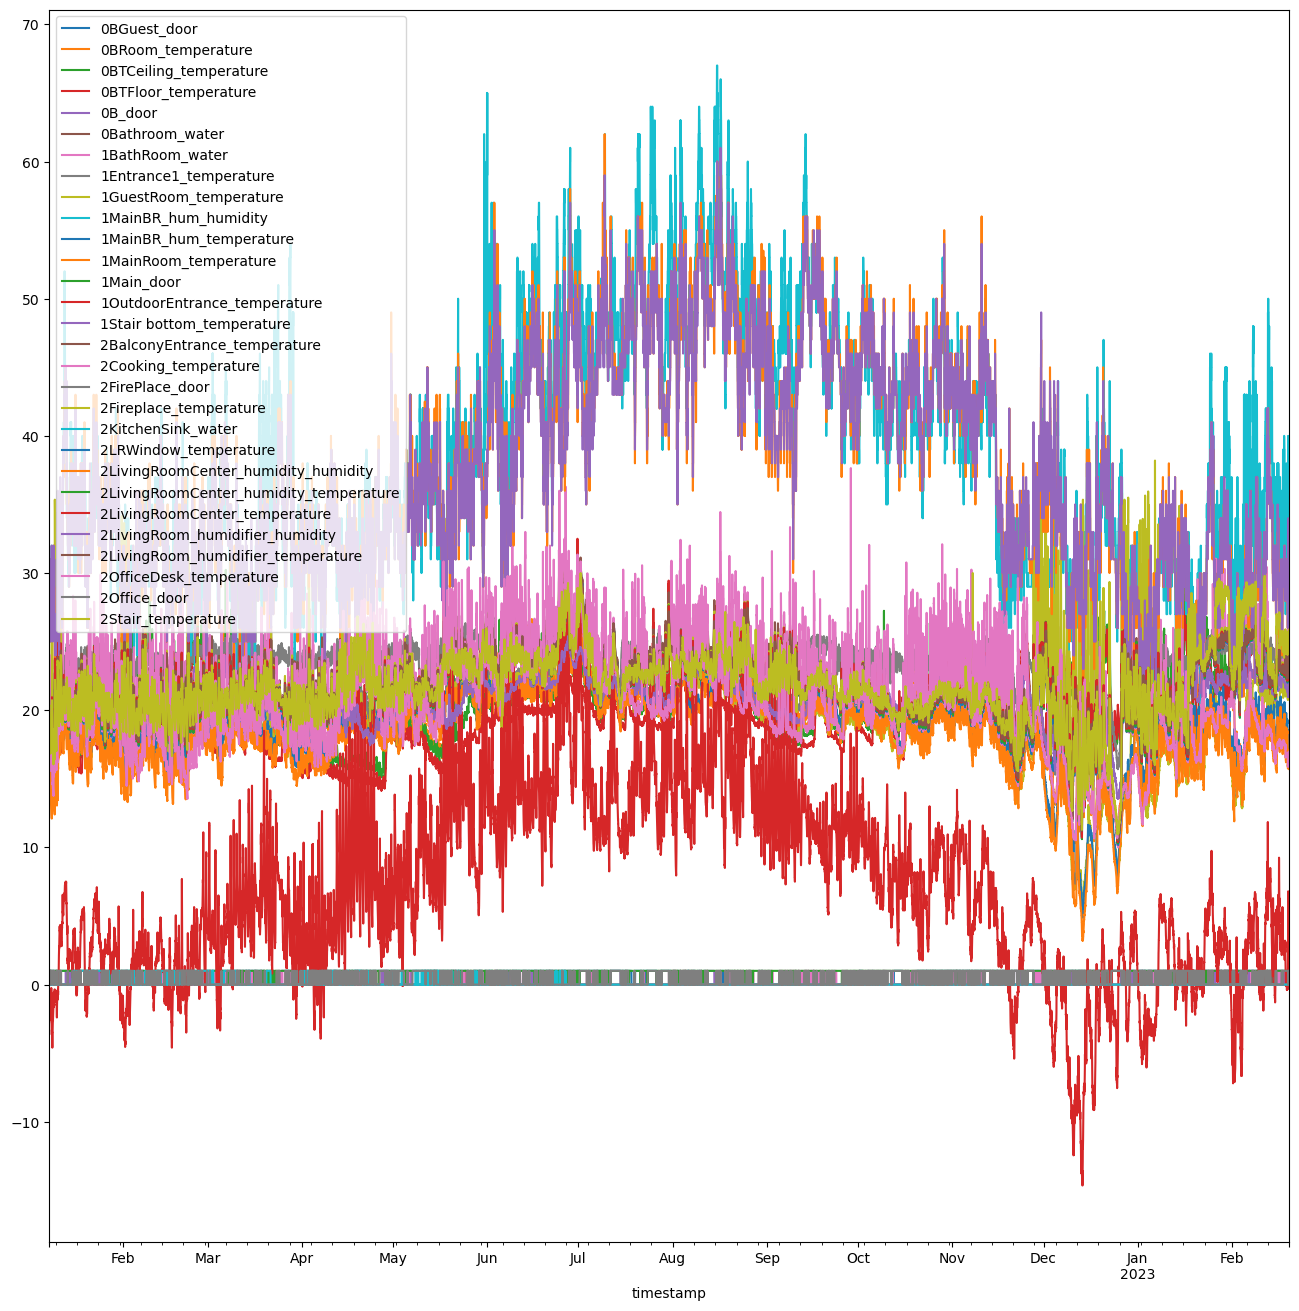

In [5]:
#plot the data
sensor_data.plot(figsize=(16, 16))

### FEATURE ENGINEERING ###

In [6]:
#Add hand-designed time-of-day and day-of-year features
min_in_hour = 60
min_in_day = 24*min_in_hour
sensor_data['sin_daily'] = np.sin(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values
sensor_data['cos_daily'] = np.cos(2*np.pi*(sensor_data.index.minute + sensor_data.index.hour*min_in_hour)/min_in_day).values

days_in_year = 365.2425
sensor_data['sin_yearly'] = np.sin(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values
sensor_data['cos_yearly'] = np.cos(2*np.pi*(sensor_data.index.day_of_year)/days_in_year).values

days_in_week = 7
sensor_data['sin_weekly'] = np.sin(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values
sensor_data['cos_weekly'] = np.cos(2*np.pi*(sensor_data.index.day_of_week)/days_in_week).values

In [7]:
sensor_data.describe()

,0BGuest_door,0BRoom_temperature,0BTCeiling_temperature,0BTFloor_temperature,0B_door,0Bathroom_water,1BathRoom_water,1Entrance1_temperature,1GuestRoom_temperature,1MainBR_hum_humidity,...,2LivingRoom_humidifier_temperature,2OfficeDesk_temperature,2Office_door,2Stair_temperature,sin_daily,cos_daily,sin_yearly,cos_yearly,sin_weekly,cos_weekly
count,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,39166.000000,...,39166.000000,39166.000000,39166.000000,39166.000000,3.916600e+04,3.916600e+04,39166.000000,39166.000000,39166.000000,39166.000000
mean,0.731093,20.219920,20.493444,19.880145,0.159577,0.003396,0.113925,23.061776,18.888458,38.371860,...,21.596080,20.351772,0.398739,21.664779,4.776617e-05,-1.797791e-05,0.048966,0.089977,-0.004115,0.000289
std,0.443397,2.777353,2.358416,2.570392,0.366218,0.058175,0.317725,1.703731,3.133083,9.052182,...,2.549447,3.360557,0.489645,2.543805,7.071023e-01,7.071294e-01,0.686751,0.719656,0.707943,0.706275
min,0.000000,10.250000,15.100000,14.150000,0.000000,0.000000,0.000000,15.300000,5.700000,19.000000,...,10.550000,10.525000,0.000000,10.950000,-1.000000e+00,-1.000000e+00,-0.999999,-0.999979,-0.974928,-0.900969
25%,0.000000,18.800000,18.750000,18.050000,0.000000,0.000000,0.000000,22.300000,17.650000,31.000000,...,20.100000,18.383333,0.000000,20.250000,-7.071068e-01,-7.071068e-01,-0.639648,-0.641690,-0.781831,-0.900969
50%,1.000000,20.200000,20.483333,19.750000,0.000000,0.000000,0.000000,23.450000,19.200000,37.000000,...,21.550000,20.200000,0.000000,21.583333,1.224647e-16,-1.836970e-16,0.164758,0.176443,0.000000,-0.222521
75%,1.000000,22.000000,22.100000,21.650000,0.000000,0.000000,0.000000,24.250000,20.925000,45.000000,...,23.300000,22.366667,1.000000,23.116667,7.071068e-01,7.071068e-01,0.681936,0.811856,0.781831,0.623490
max,1.000000,27.450000,31.550000,27.750000,1.000000,1.000000,1.000000,26.900000,28.200000,67.000000,...,30.700000,32.425000,1.000000,30.000000,1.000000e+00,1.000000e+00,0.999986,0.999991,0.974928,1.000000


### DATA PREPROCESSING

In [219]:
train_val_df = sensor_data.iloc[:int(sensor_data.shape[0]*0.9)]
test_df = sensor_data.iloc[int(sensor_data.shape[0]*0.9):]

train_val_split = int(train_val_df.shape[0]*0.8)
train_df = train_val_df[:train_val_split]
val_df = train_val_df[train_val_split:]

train_labels = train_df.loc[:, sensor_data.columns.str.endswith('temperature')].drop("1OutdoorEntrance_temperature", axis=1).sort_index(axis=1)

x_scaler = StandardScaler()
y_scaler = StandardScaler()

x_scaler.fit(train_df)
y_scaler.fit(train_labels)

train_df_scaled = x_scaler.fit_transform(train_df)
train_df_scaled = pd.DataFrame(train_df_scaled, columns=train_df.columns)
val_df_scaled = x_scaler.transform(val_df)
val_df_scaled = pd.DataFrame(val_df_scaled, columns=val_df.columns)
test_df_scaled = x_scaler.transform(test_df)
test_df_scaled = pd.DataFrame(test_df_scaled, columns=test_df.columns)


print(f"Shape of train_df = {train_df.shape}, Shape of val_df = {val_df.shape}, Shape of test_df = {test_df.shape}")
print(f"Shape of labels = {train_labels.shape}")

Shape of train_df = (28199, 35), Shape of val_df = (7050, 35), Shape of test_df = (3917, 35)
Shape of labels = (28199, 17)


In [423]:
import WindowGenerator
import importlib
importlib.reload(WindowGenerator)

measurements_per_day = 4*24
sequence_width = 2*measurements_per_day
label_width = 8#measurements_per_day
shift = 0

train_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift, train_df_scaled, train_labels.columns)
val_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift, val_df_scaled, train_labels.columns)
test_windows = WindowGenerator.WindowGenerator(sequence_width, label_width, shift, test_df_scaled, train_labels.columns)

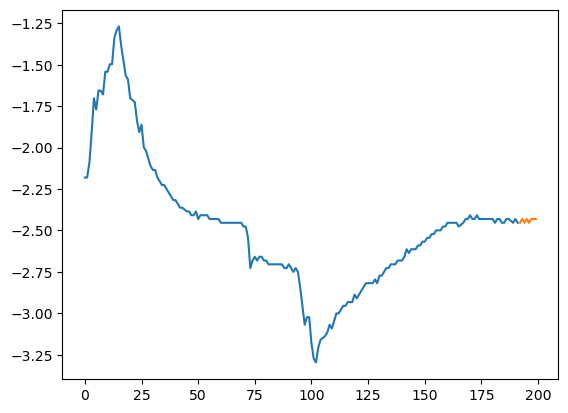

In [424]:
x_1 = train_windows[0][0][:,1]
x_2 = train_windows[0][1][:,0]
plt.plot(range(len(x_1)), x_1)
plt.plot(range(len(x_1), len(x_1)+len(x_2)), x_2)

In [425]:
train_windows[0][0][:,0].shape

torch.Size([192])

In [426]:
batch_size = 1000
train_loader = DataLoader(train_windows, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_windows, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_windows, batch_size=len(test_windows), shuffle=False)

X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1000, 192, 35])
Target shape: torch.Size([1000, 8, 17])


### LSTM

In [434]:
import LSTMModel
import importlib
importlib.reload(LSTMModel)

model = LSTMModel.Net(input_size=35, hidden_size=256, output_shape=(label_width, 17), num_lstm_layers=1, linear_layers=[256])

epochs = 20
lr = 0.01
l2_reg = 1e-3
LSTMModel.train(model, train_loader, val_loader, epochs, lr, l2_reg)

Epoch: 1, Test loss: 1.7955623865127563
Epoch: 1: Val MSE: 2.5948455333709717


: 

: 

In [ ]:
print(model)

Net(
  (lstm): LSTM(35, 256, batch_first=True)
  (linear_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=136, bias=True)
  )
  (act): ReLU()
)


In [428]:
eval_windows_index = np.random.choice(range(0, len(train_windows)-1), 4)
eval_windows = [train_windows[i] for i in eval_windows_index]

input_seq_unscaled = [x_scaler.inverse_transform(input[0]) for input in eval_windows]

outputs = []
ground_truth = []
input_seq = []
for window in eval_windows:
    output = model(window[0].reshape(1, window[0].shape[0], window[0].shape[1]))
    outputs.append(y_scaler.inverse_transform(output[0].detach().numpy()))

    ground_truth.append(y_scaler.inverse_transform(window[1]))
    input_seq.append(x_scaler.inverse_transform(window[0]))

temp_mask = [(column in train_labels) for column in sensor_data.columns]
temp_indices = [i for i, x in enumerate(temp_mask) if x == True]
temp_input_seq = []
for input in input_seq:
    temp_single_input = []
    for i in input:
        temp_single_input.append(np.array(i[temp_indices]))
    temp_input_seq.append(np.array(temp_single_input))

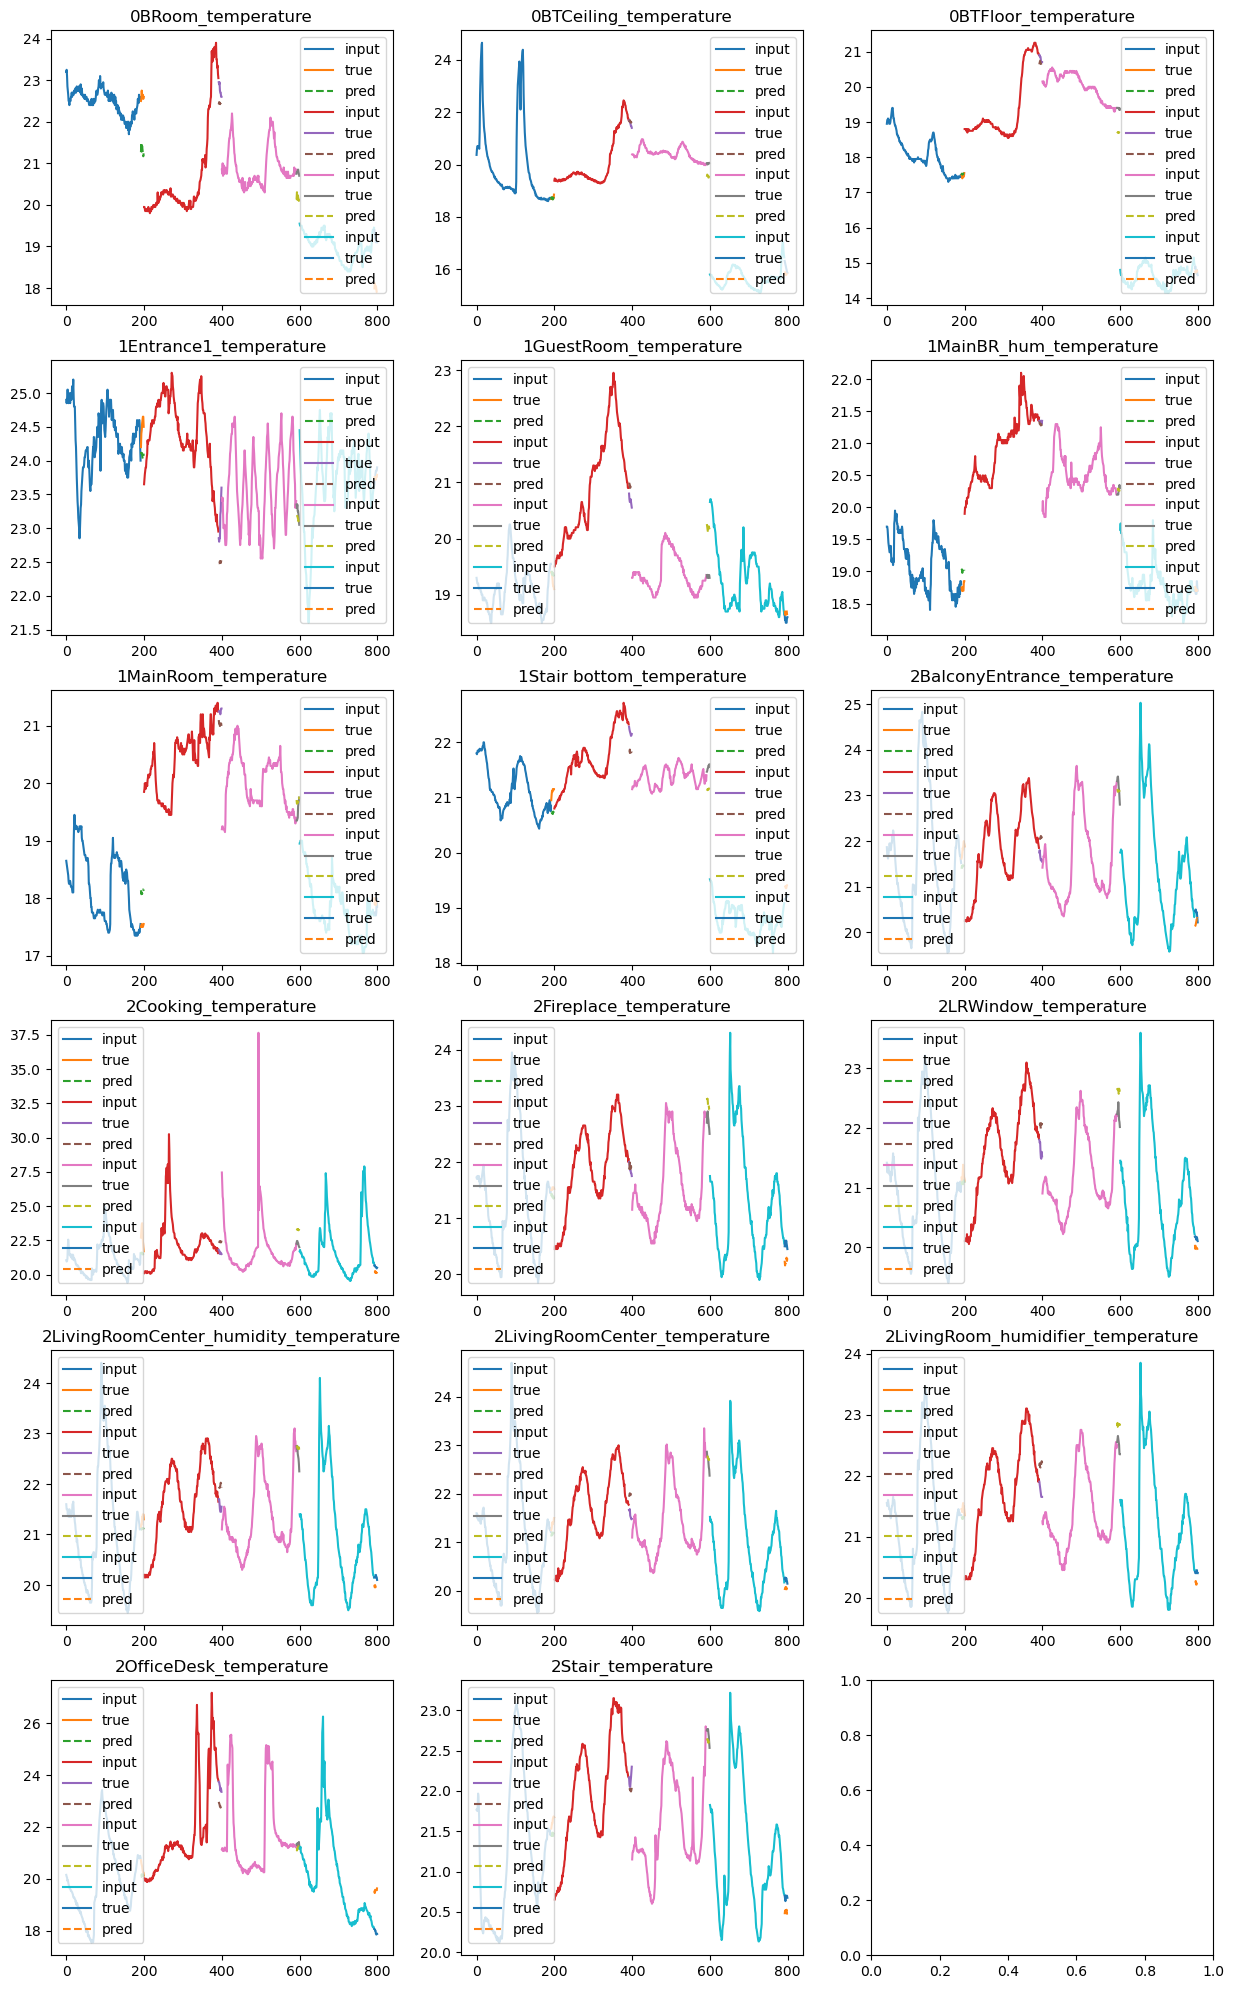

In [429]:
fig,ax = plt.subplots(6,3,figsize=(15,25))
for j in range(len(outputs)):
    for i in range(outputs[0].shape[1]):
        offset = j * (len(temp_input_seq[j][:, i]) + outputs[j].shape[0])
        input_indices = range(offset, offset + len(temp_input_seq[j][:, i]))
        pred_indices = range(offset + len(input_indices), offset + len(input_indices) + outputs[j].shape[0])
        ax[i//3, i%3].plot(input_indices, temp_input_seq[j][:, i], label="input")
        ax[i//3, i%3].plot(pred_indices, ground_truth[j][:, i], label="true")
        ax[i//3, i%3].plot(pred_indices, outputs[j][:,i], '--', label="pred")
        ax[i//3, i%3].set_title(f"{train_labels.columns[i]}")
        ax[i//3, i%3].legend()

In [430]:
eval_windows_index = np.random.choice(range(0, len(test_windows)-1), 4)
eval_windows = [test_windows[i] for i in eval_windows_index]

input_seq_unscaled = [x_scaler.inverse_transform(input[0]) for input in eval_windows]

outputs = []
ground_truth = []
input_seq = []
for window in eval_windows:
    output = model(window[0].reshape(1, window[0].shape[0], window[0].shape[1]))
    outputs.append(y_scaler.inverse_transform(output[0].detach().numpy()))

    ground_truth.append(y_scaler.inverse_transform(window[1]))
    input_seq.append(x_scaler.inverse_transform(window[0]))

temp_mask = [(column in labels) for column in sensor_data.columns]
temp_indices = [i for i, x in enumerate(temp_mask) if x == True]
temp_input_seq = []
for input in input_seq:
    temp_single_input = []
    for i in input:
        temp_single_input.append(np.array(i[temp_indices]))
    temp_input_seq.append(np.array(temp_single_input))

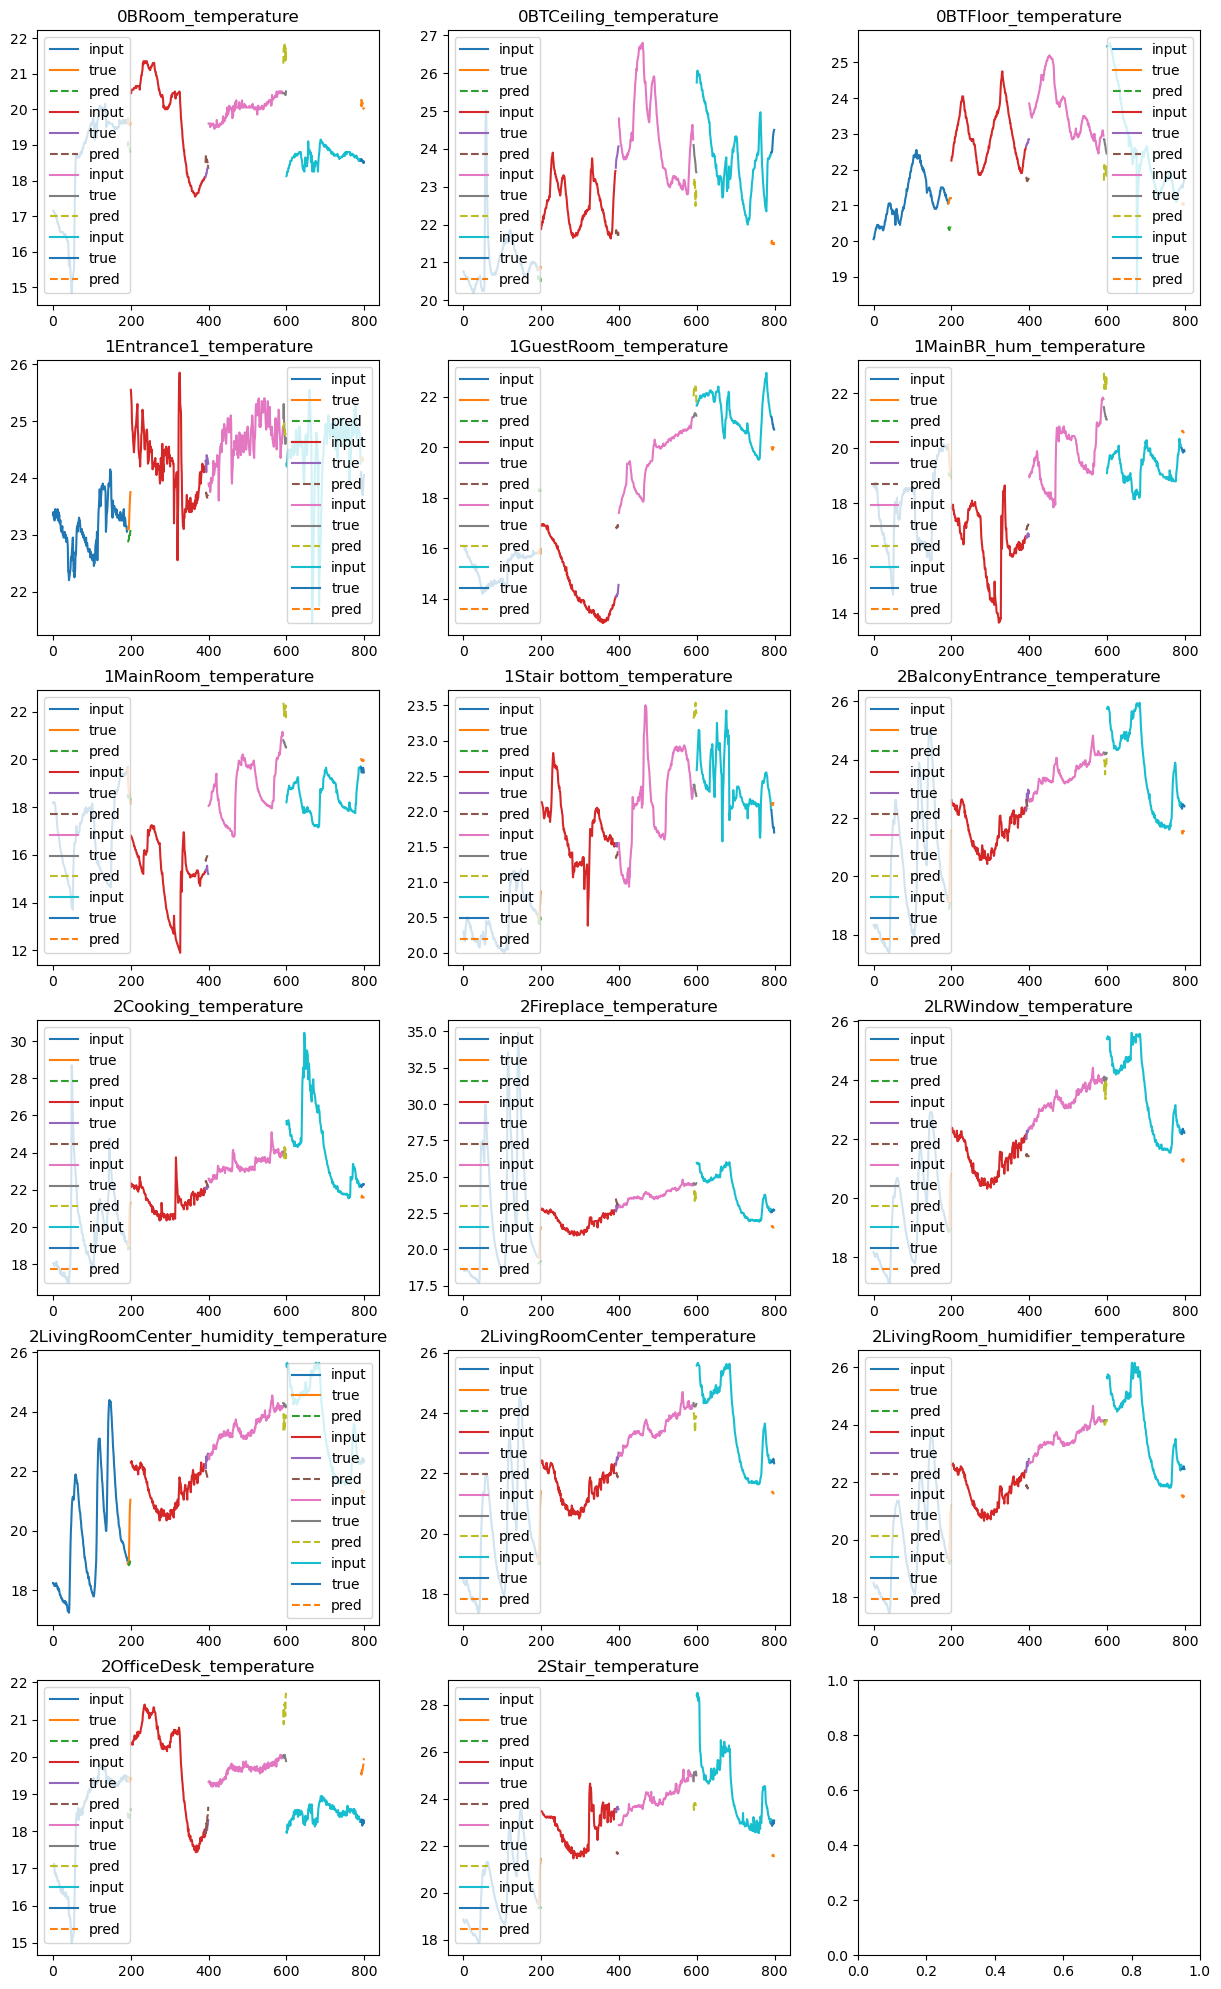

In [431]:
fig,ax = plt.subplots(6,3,figsize=(15,25))
for j in range(len(outputs)):
    for i in range(outputs[0].shape[1]):
        offset = j * (len(temp_input_seq[j][:, i]) + outputs[j].shape[0])
        input_indices = range(offset, offset + len(temp_input_seq[j][:, i]))
        pred_indices = range(offset + len(input_indices), offset + len(input_indices) + outputs[j].shape[0])
        ax[i//3, i%3].plot(input_indices, temp_input_seq[j][:, i], label="input")
        ax[i//3, i%3].plot(pred_indices, ground_truth[j][:, i], label="true")
        ax[i//3, i%3].plot(pred_indices, outputs[j][:,i], '--', label="pred")
        ax[i//3, i%3].set_title(f"{labels.columns[i]}")
        ax[i//3, i%3].legend()

### EXAMINE MODEL

In [432]:
val_windows

Window sizes: 200
Num train windows: 6850

In [433]:
# Predict on validation data
pred_val_inv = x_scaler.inverse_transform(model(val_windows).detach())
# pred_val = torch.from_numpy(pred_val).to(torch.float)
y_val_inv = y_scaler.inverse_transform(y_val_norm. reshape(y_val_norm.shape[0], -1))

# Compute MSE, MAE and MAPE on validation data
print('Error on validation data')

mse_val = np.mean(np.power((pred_val_inv - y_val_inv), 2))
print(f'MSE: {mse_val.item()}')

mae_val = np.mean(np.abs(pred_val_inv - y_val_inv))
print(f'MAE: {mae_val.item()}')

mape_val = 100*np.mean(np.abs(np.divide(pred_val_inv - y_val_inv, y_val_inv)))
print(f'MAPE: {mape_val.item()} %')

AttributeError: 'WindowGenerator' object has no attribute 'size'

In [ ]:
net.eval()
pred_train = y_scaler.inverse_transform(net(x_val_norm).detach().numpy())
true_train = y_scaler.inverse_transform(y_val_norm.reshape(y_val_norm.shape[0], -1).detach().numpy())
net.train()

fig,ax = plt.subplots(6,3,figsize=(15,25))
for i in range(train_labels.shape[1]):
    ax[i//3, i%3].plot(true_train[:100, i], label="true")
    ax[i//3, i%3].plot(pred_train[:100, i], '--', label="pred")
    ax[i//3, i%3].set_title(f"{train_labels.columns[i]}")
    ax[i//3, i%3].legend()

### FORECAST

In [ ]:
current_state = x_val_norm[0].reshape(1, x_val_norm[0].shape[0], x_val_norm[0].shape[1])
current_state.shape

In [ ]:
net(x_test_norm[0].reshape(1, x_test_norm[0].shape[0], x_test_norm[0].shape[1]))


### PyTorch Forecasting library